## Syndrome extraction

The syndrome extraction protocol operates by detecting changes in stabilizer measurement outcomes that ideally give a $0$ measurement result. Because syndrome extraction requires the use of noisy gates, syndrome measurements must be repeated multiple times within a single QEC cycle to be FT to syndrome measurement errors.


<img src="./pic/quantinuum_colorcode.png" width="400"/>

In [43]:
# Imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

simulator = Aer.get_backend('aer_simulator')

stabilizers = [
    [1,2,3,4],
    [2,3,5,6],
    [3,4,6,7]
]

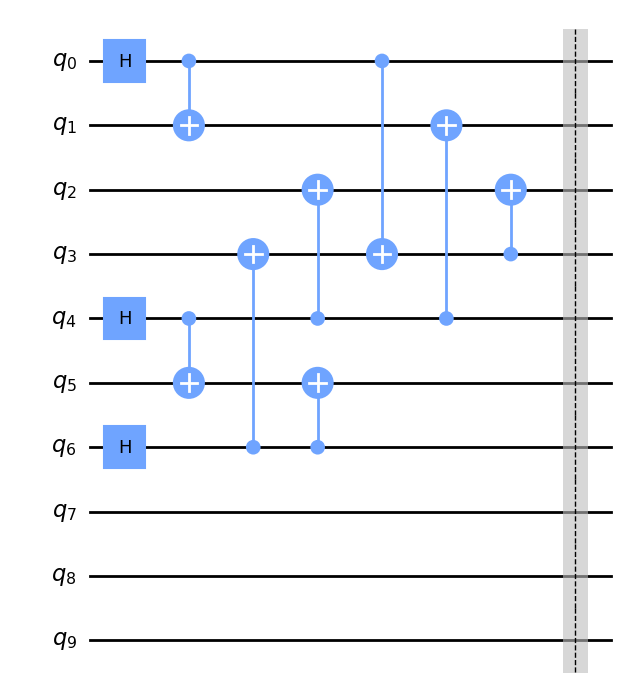

In [44]:
qreg = QuantumRegister(10, "q")
encoding_circuit = QuantumCircuit(qreg)

# Encoding circuit to create the logical basis states
encoding_circuit.h(qreg[0])
encoding_circuit.h(qreg[4])
encoding_circuit.h(qreg[6])
encoding_circuit.cx(qreg[0], qreg[1])
encoding_circuit.cx(qreg[4], qreg[5])
encoding_circuit.cx(qreg[6], qreg[3])
encoding_circuit.cx(qreg[4], qreg[2])
encoding_circuit.cx(qreg[6], qreg[5])
encoding_circuit.cx(qreg[0], qreg[3])
encoding_circuit.cx(qreg[4], qreg[1])
encoding_circuit.cx(qreg[3], qreg[2])
encoding_circuit.barrier()

encoding_circuit.draw("mpl")

## Unflagged circuits $\{S_1, S_2, S_3, S_4, S_5, S_6\}$

<img src="./pic/unflagged-circuits.png" width="200"/>

### Parallel check $\{S_1, S_2, S_3\}$

The following is an example of single qubit phase-flip $Z$ error happening on the 3rd data qubit $q_2$. This error can be detected with stabilizers $\{S_1, S_2, S_3\}$.

In [45]:
def construct_unflagged_syndrome_xxx_circuit(qreg, creg):
    unflagged_syndrome_xxx_circuit = QuantumCircuit(qreg, creg)

    unflagged_syndrome_xxx_circuit &= encoding_circuit

    # Add phase flip Z error
    unflagged_syndrome_xxx_circuit.z(2)
    # unflagged_syndrome_xxx.x(2)
    unflagged_syndrome_xxx_circuit.barrier()

    # Stablizer measuremnt S1, S2, S3
    for s in range(len(stabilizers)):
        stabilizer = stabilizers[s]

        unflagged_syndrome_xxx_circuit.h(qreg[7 + s])

        for qubit_num in stabilizer:
            unflagged_syndrome_xxx_circuit.cx(qreg[7 + s], qreg[qubit_num - 1])

        unflagged_syndrome_xxx_circuit.h(qreg[7 + s])

        unflagged_syndrome_xxx_circuit.barrier()

    unflagged_syndrome_xxx_circuit.measure(qreg[7:], creg)

    return unflagged_syndrome_xxx_circuit

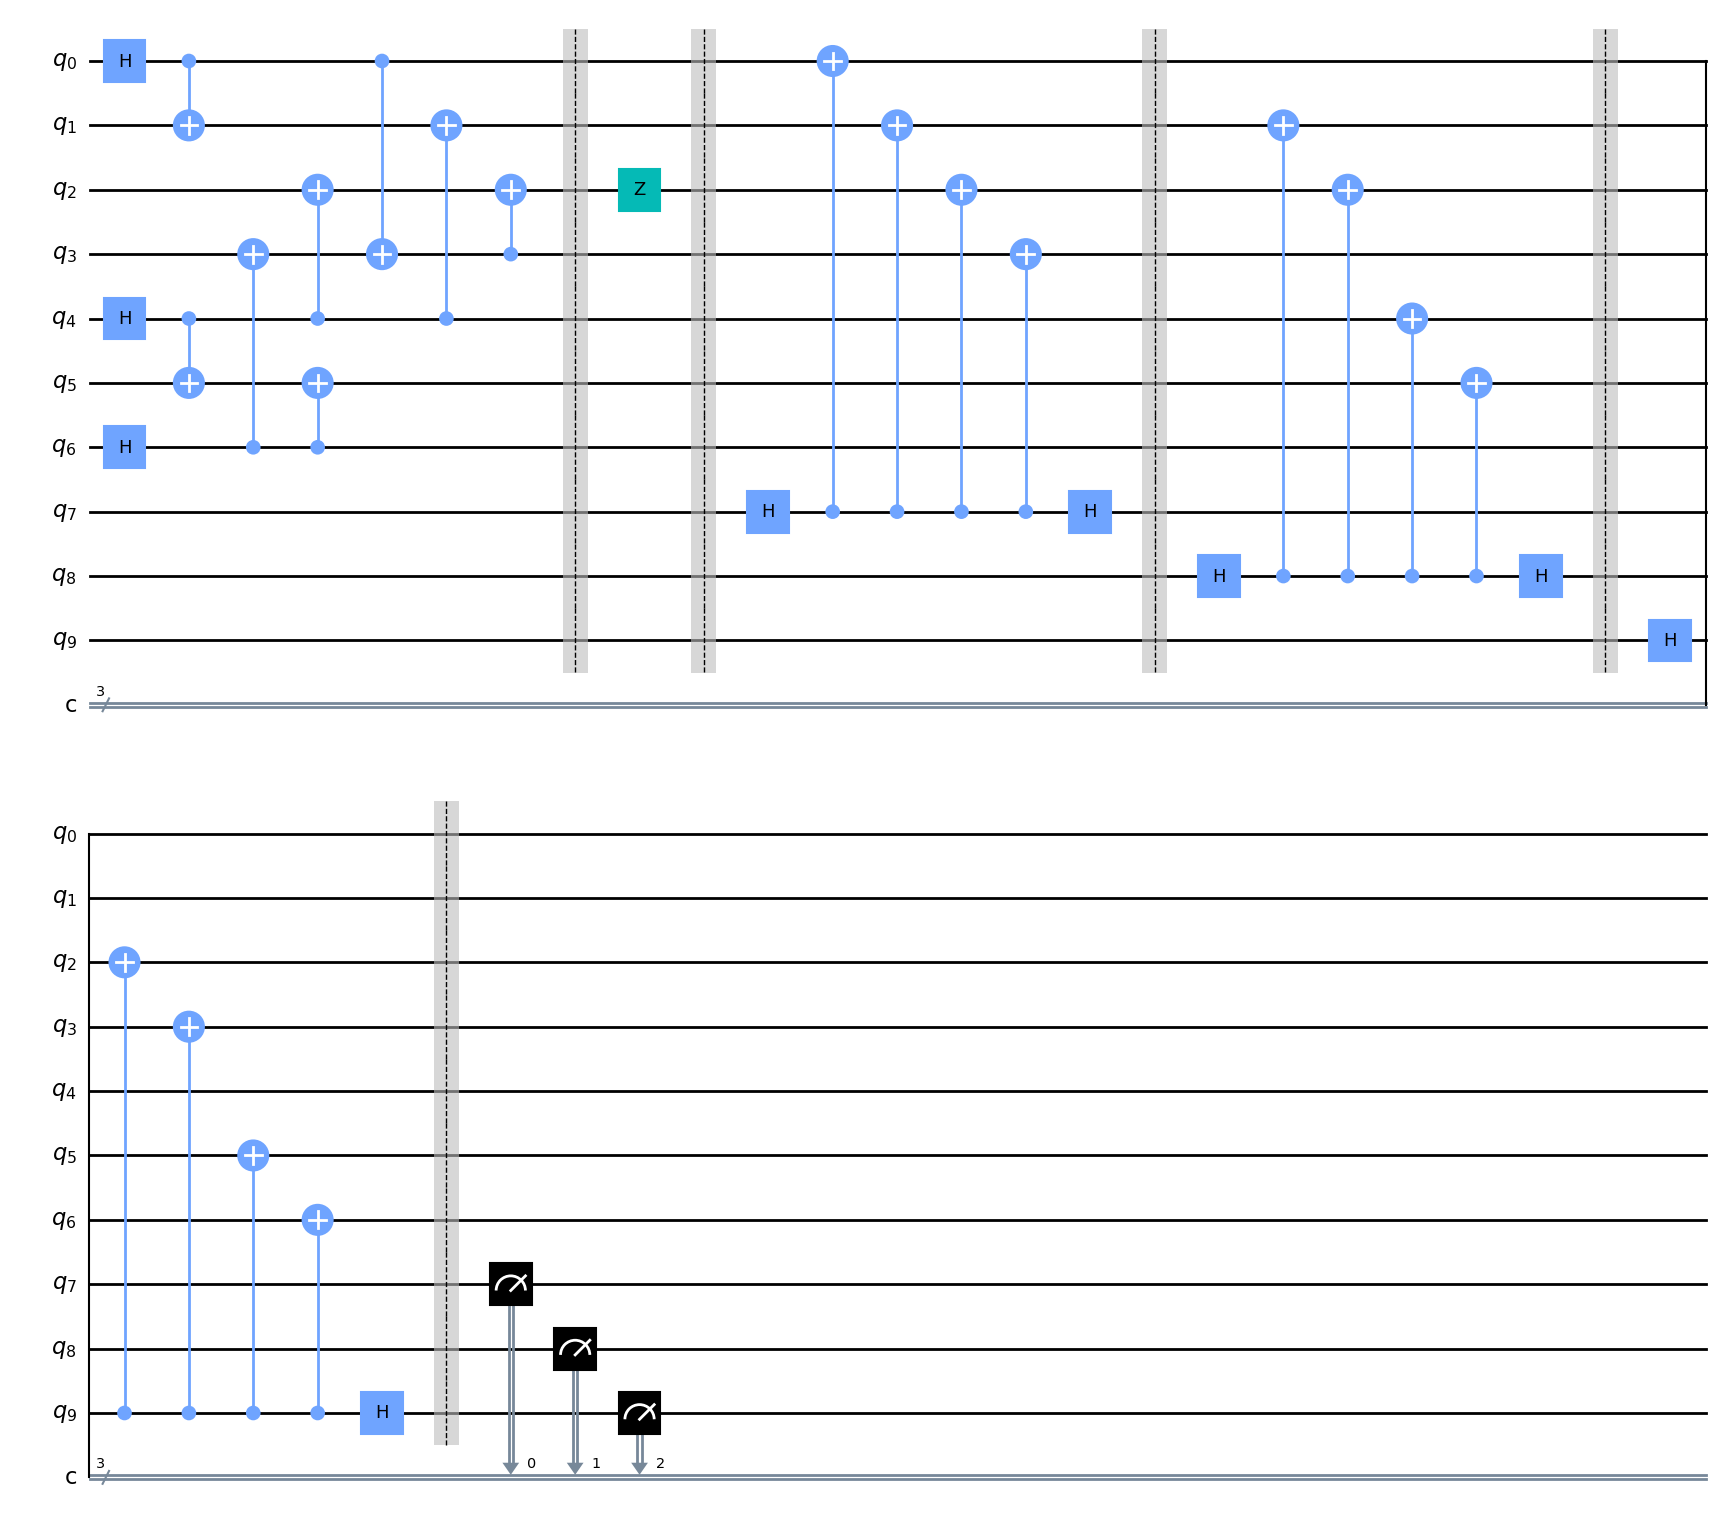

In [46]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

unflagged_syndrome_xxx_circuit = construct_unflagged_syndrome_xxx_circuit(qreg, creg)
unflagged_syndrome_xxx_circuit.draw("mpl")

In [47]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')

# Run and get counts
result = simulator.run(unflagged_syndrome_xxx_circuit.reverse_bits(), shots=1000).result()
counts = result.get_counts(unflagged_syndrome_xxx_circuit)
print(counts)

{'111': 1000}


Now, let's interpret the results. We get a measurement result of $111$. 

- The first flag ancilla qubit checks $S_1 = X_1X_2X_3X_4$. $1$ tells us there is one $X$ error happening on those qubit. 

- The second flag ancilla qubit checks $S_2 = X_2X_3X_5X_6$. $1$ tells us there is one $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S_3 = X_3X_4X_6X_7$. $1$ tells us there is one $X$ error happening on those qubit.

By comparing $S_1$, $S_2$ and $S_3$ syndromes, we can claim that only $q_2$ experience a $Z$ error.

**Notice:** These syndromes won't detect any $X$ error! You can replace `unflagged_syndrome_xxx.z(2)` with `unflagged_syndrome_xxx.x(2)` and see what will happen.

### Parallel check $\{S_4, S_5, S_6\}$

The following is an example of single qubit bit-flip $X$ error happening on the 2nd data qubit $q_1$. This error can be detected with stabilizers $\{S_4, S_5, S_6\}$.

In [48]:
def construct_unflagged_syndrome_zzz_circuit(qreg, creg):
    unflagged_syndrome_zzz_circuit = QuantumCircuit(qreg, creg)

    unflagged_syndrome_zzz_circuit &= encoding_circuit

    # Add bit flip X error
    unflagged_syndrome_zzz_circuit.x(1)
    unflagged_syndrome_zzz_circuit.barrier()

    # Stablizer measuremnt S4, S5, S6
    for s in range(len(stabilizers)):
        stabilizer = stabilizers[s]
        for qubit_num in stabilizer:
            unflagged_syndrome_zzz_circuit.cx(qreg[qubit_num - 1], qreg[7 + s])
        unflagged_syndrome_zzz_circuit.barrier()

    unflagged_syndrome_zzz_circuit.measure(qreg[7:], creg)

    return unflagged_syndrome_zzz_circuit


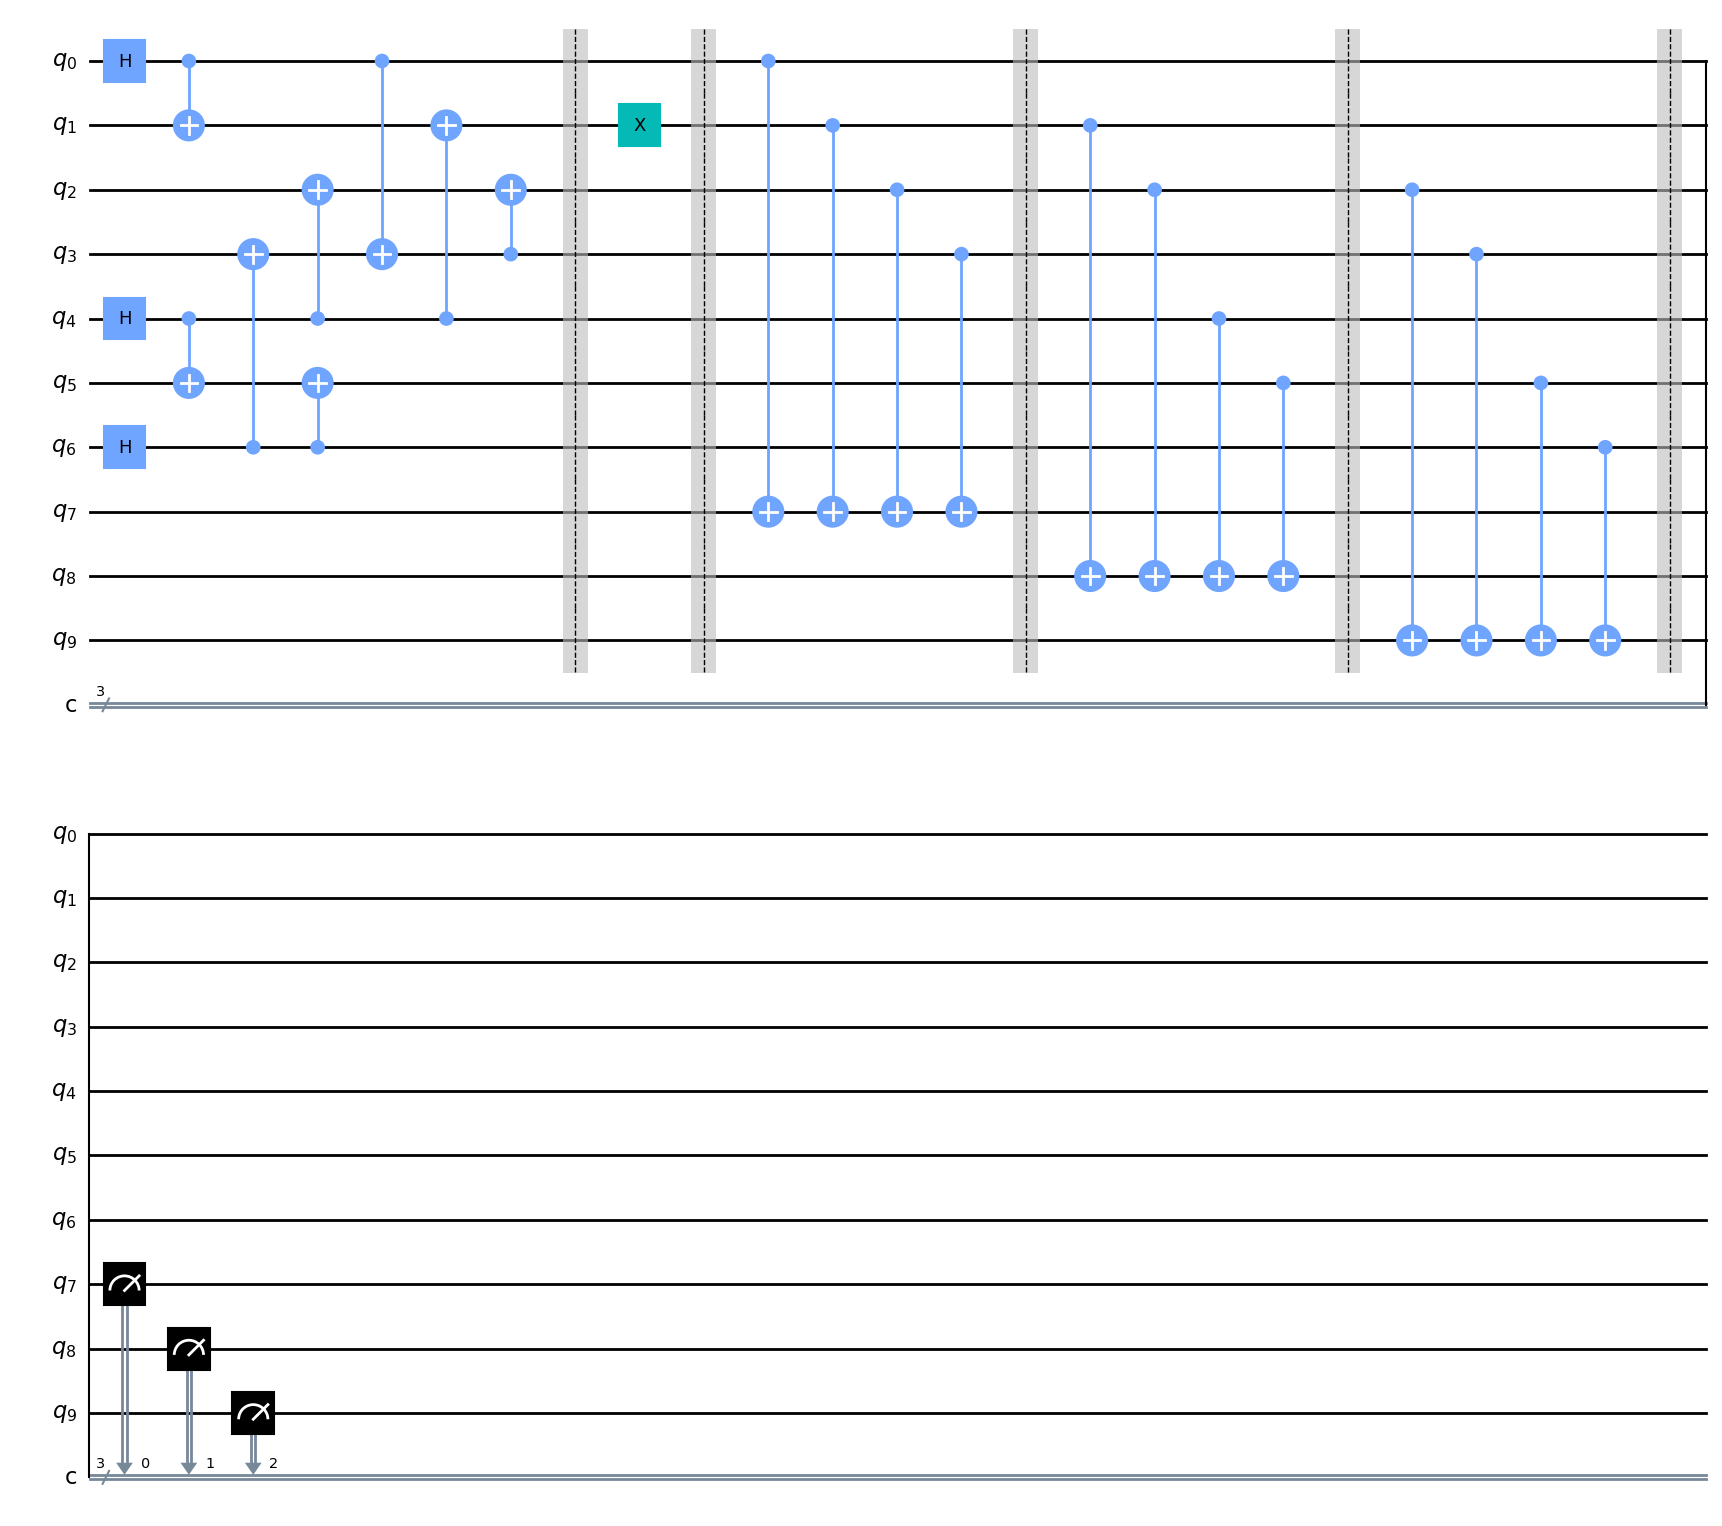

In [49]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

unflagged_syndrome_zzz_circuit = construct_unflagged_syndrome_zzz_circuit(qreg, creg)
unflagged_syndrome_zzz_circuit.draw("mpl")

In [50]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')

# Run and get counts
result = simulator.run(unflagged_syndrome_zzz_circuit.reverse_bits(), shots=100000).result()
counts = result.get_counts(unflagged_syndrome_zzz_circuit)
print(counts)

{'110': 100000}


Now, let's interpret the results. We get a measurement result of $110$. 

- The first flag ancilla qubit checks $S_4 = Z_1Z_2Z_3Z_4$. $1$ tells us there is one $X$ error happening on those qubit. 

- The second flag ancilla qubit checks $S_5 = Z_2Z_3Z_5Z_6$. $1$ tells us there is one $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S_6 = Z_3Z_4Z_6Z_7$. $0$ tells us there is no $X$ error happening on those qubit.

By comparing $S_4$ and $S_5$ syndromes, we can claim that either $q_1$ or $q_2$ experience a bit-flip $X$ error. But $S_6$ tells us that no error happens on $q_2$. So, we can conclude that $q_1$ is the qubit we need to correct.

### Lookup table for unflagged syndromes



| S1/S4 | S2/S5 | S3/S6 | which_qubit | correction |
| :------: | :------: | :------: | :----------: | :---------: |
| 0       | 0       | 0       | N/A         | Z/X        |
| 1       | 0       | 0       | $q_0$       | Z/X        |
| 0       | 1       | 0       | $q_4$       | Z/X        |
| 0       | 0       | 1       | $q_6$       | Z/X        |
| 1       | 1       | 0       | $q_1$       | Z/X        |
| 0       | 1       | 1       | $q_5$       | Z/X        |
| 1       | 0       | 1       | $q_3$       | Z/X        |
| 1       | 1       | 1       | $q_2$       | Z/X        |


<img src="./pic/unflagged_table.png" width="500"/>

---

## First flagged parallel circuit $\{S^f_1, S^f_5, S^f_6\}$

<img src="./pic/first-flag.png" width="500"/>


### Single qubit error

The following is an example of single qubit bit-flip $X$ error happening on the 7-th data qubit $q_6$ (Fig.11 from Quantinuum's paper).


In [51]:
def construct_flagged_syndrome_xzz_circuit(qreg, creg):
    flagged_syndrome_xzz_circuit = QuantumCircuit(qreg, creg)

    flagged_syndrome_xzz_circuit &= encoding_circuit

    # Add single qubit bit-flip error
    flagged_syndrome_xzz_circuit.x(qreg[6])
    flagged_syndrome_xzz_circuit.barrier()

    # Stablizer measuremnt S1, S5, S6
    flagged_syndrome_xzz_circuit.h(qreg[7])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[3])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[0])
    flagged_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[4],qreg[8])

    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[1])
    flagged_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[2])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
    flagged_syndrome_xzz_circuit.h(qreg[7])

    flagged_syndrome_xzz_circuit.barrier()

    flagged_syndrome_xzz_circuit.measure(qreg[7], creg[0])
    flagged_syndrome_xzz_circuit.measure(qreg[8], creg[1])
    flagged_syndrome_xzz_circuit.measure(qreg[9], creg[2])

    return flagged_syndrome_xzz_circuit


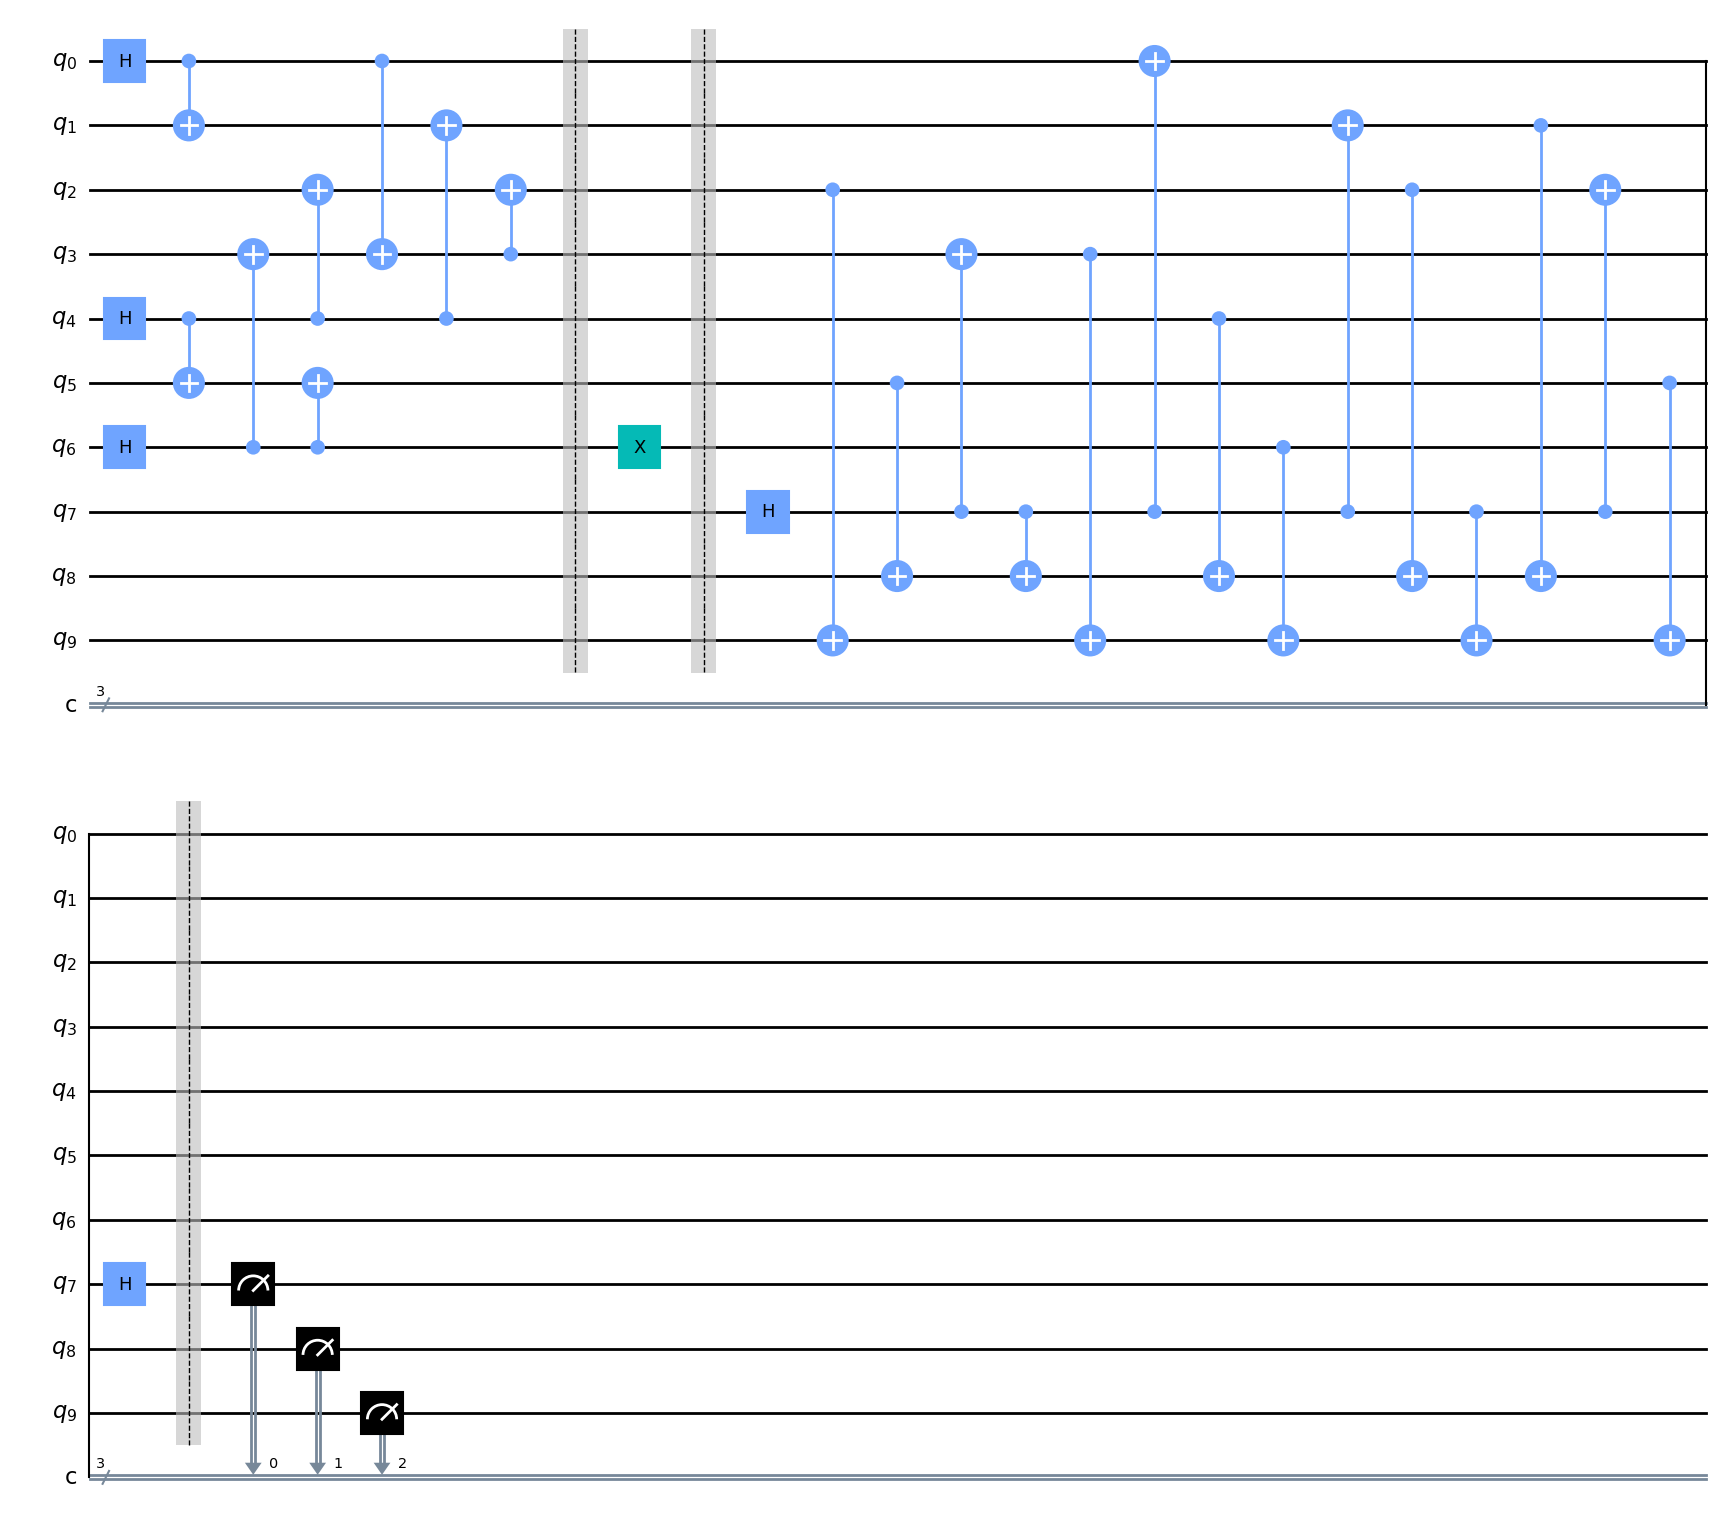

In [52]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flagged_syndrome_xzz_circuit = construct_flagged_syndrome_xzz_circuit(qreg, creg)
flagged_syndrome_xzz_circuit.draw('mpl')

In [53]:
# Run and get counts
result = simulator.run(flagged_syndrome_xzz_circuit.reverse_bits(), shots=1000).result()
counts = result.get_counts(flagged_syndrome_xzz_circuit)
# plot_histogram(counts, title='')
print(counts)

{'001': 1000}


Now, let's interpret the results. We get a measurement result of $001$. 

- The first flag ancilla qubit checks $S^f_1 = X_1X_2X_3X_4$. $0$ tells us there is no $Z$ error happening on those qubit. 

- The second flag ancilla qubit checks $S^f_5 = Z_2Z_3Z_5Z_6$. $0$ tells us there is no $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S^f_6 = Z_3Z_4Z_6Z_7$. $1$ tells us there is one $X$ error happening on those qubit.

![](./pic/SingleError_Quantinuum.png)


By comparing $S^f_5$ and $S^f_6$ syndromes, we can claim that either $q_3$ or $q_6$ experience a bit-flip $X$ error. Even if we narrow down to 2 candidates, we still don't know which one goes wrong exactly. According to the workflow, we will proceed to check unflagged circuits.

<img src="./pic/QEC-workflow.png" width="500"/>

After the six unflagged syndromes, we will get $S_1=S_2=S_3=S_4=S_5=0, S_6=1$ which identifies $q_6$ is the error qubit.

In [54]:
def construct_flagged_syndrome_xzz_circuit(qreg, creg):
    flagged_syndrome_xzz_circuit = QuantumCircuit(qreg, creg)

    flagged_syndrome_xzz_circuit &= encoding_circuit

    # Add single qubit bit-flip error
    flagged_syndrome_xzz_circuit.x(qreg[6])

    # Stablizer measuremnt S1+S5+S6
    flagged_syndrome_xzz_circuit.h(qreg[7])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[3])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[0])
    flagged_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[4],qreg[8])

    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[1])
    flagged_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[7],qreg[2])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
    flagged_syndrome_xzz_circuit.h(qreg[7])

    flagged_syndrome_xzz_circuit.barrier()
    flagged_syndrome_xzz_circuit.measure(qreg[7], creg[0])
    flagged_syndrome_xzz_circuit.measure(qreg[8], creg[1])
    flagged_syndrome_xzz_circuit.measure(qreg[9], creg[2])

    flagged_syndrome_xzz_circuit.barrier()
    flagged_syndrome_xzz_circuit.reset(qreg[7])
    flagged_syndrome_xzz_circuit.reset(qreg[8])
    flagged_syndrome_xzz_circuit.reset(qreg[9])

    # S4 = Z1Z2Z3Z4
    flagged_syndrome_xzz_circuit.cx(qreg[0],qreg[7])
    flagged_syndrome_xzz_circuit.cx(qreg[1],qreg[7])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[7])
    flagged_syndrome_xzz_circuit.cx(qreg[3],qreg[7])
    flagged_syndrome_xzz_circuit.barrier()

    # S5 = Z2Z3Z5Z6
    flagged_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[4],qreg[8])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
    flagged_syndrome_xzz_circuit.barrier()

    # S6 = Z3Z4Z6Z7
    flagged_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
    flagged_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
    flagged_syndrome_xzz_circuit.barrier()

    flagged_syndrome_xzz_circuit.measure(qreg[7], creg[0])
    flagged_syndrome_xzz_circuit.measure(qreg[8], creg[1])
    flagged_syndrome_xzz_circuit.measure(qreg[9], creg[2])

    return flagged_syndrome_xzz_circuit


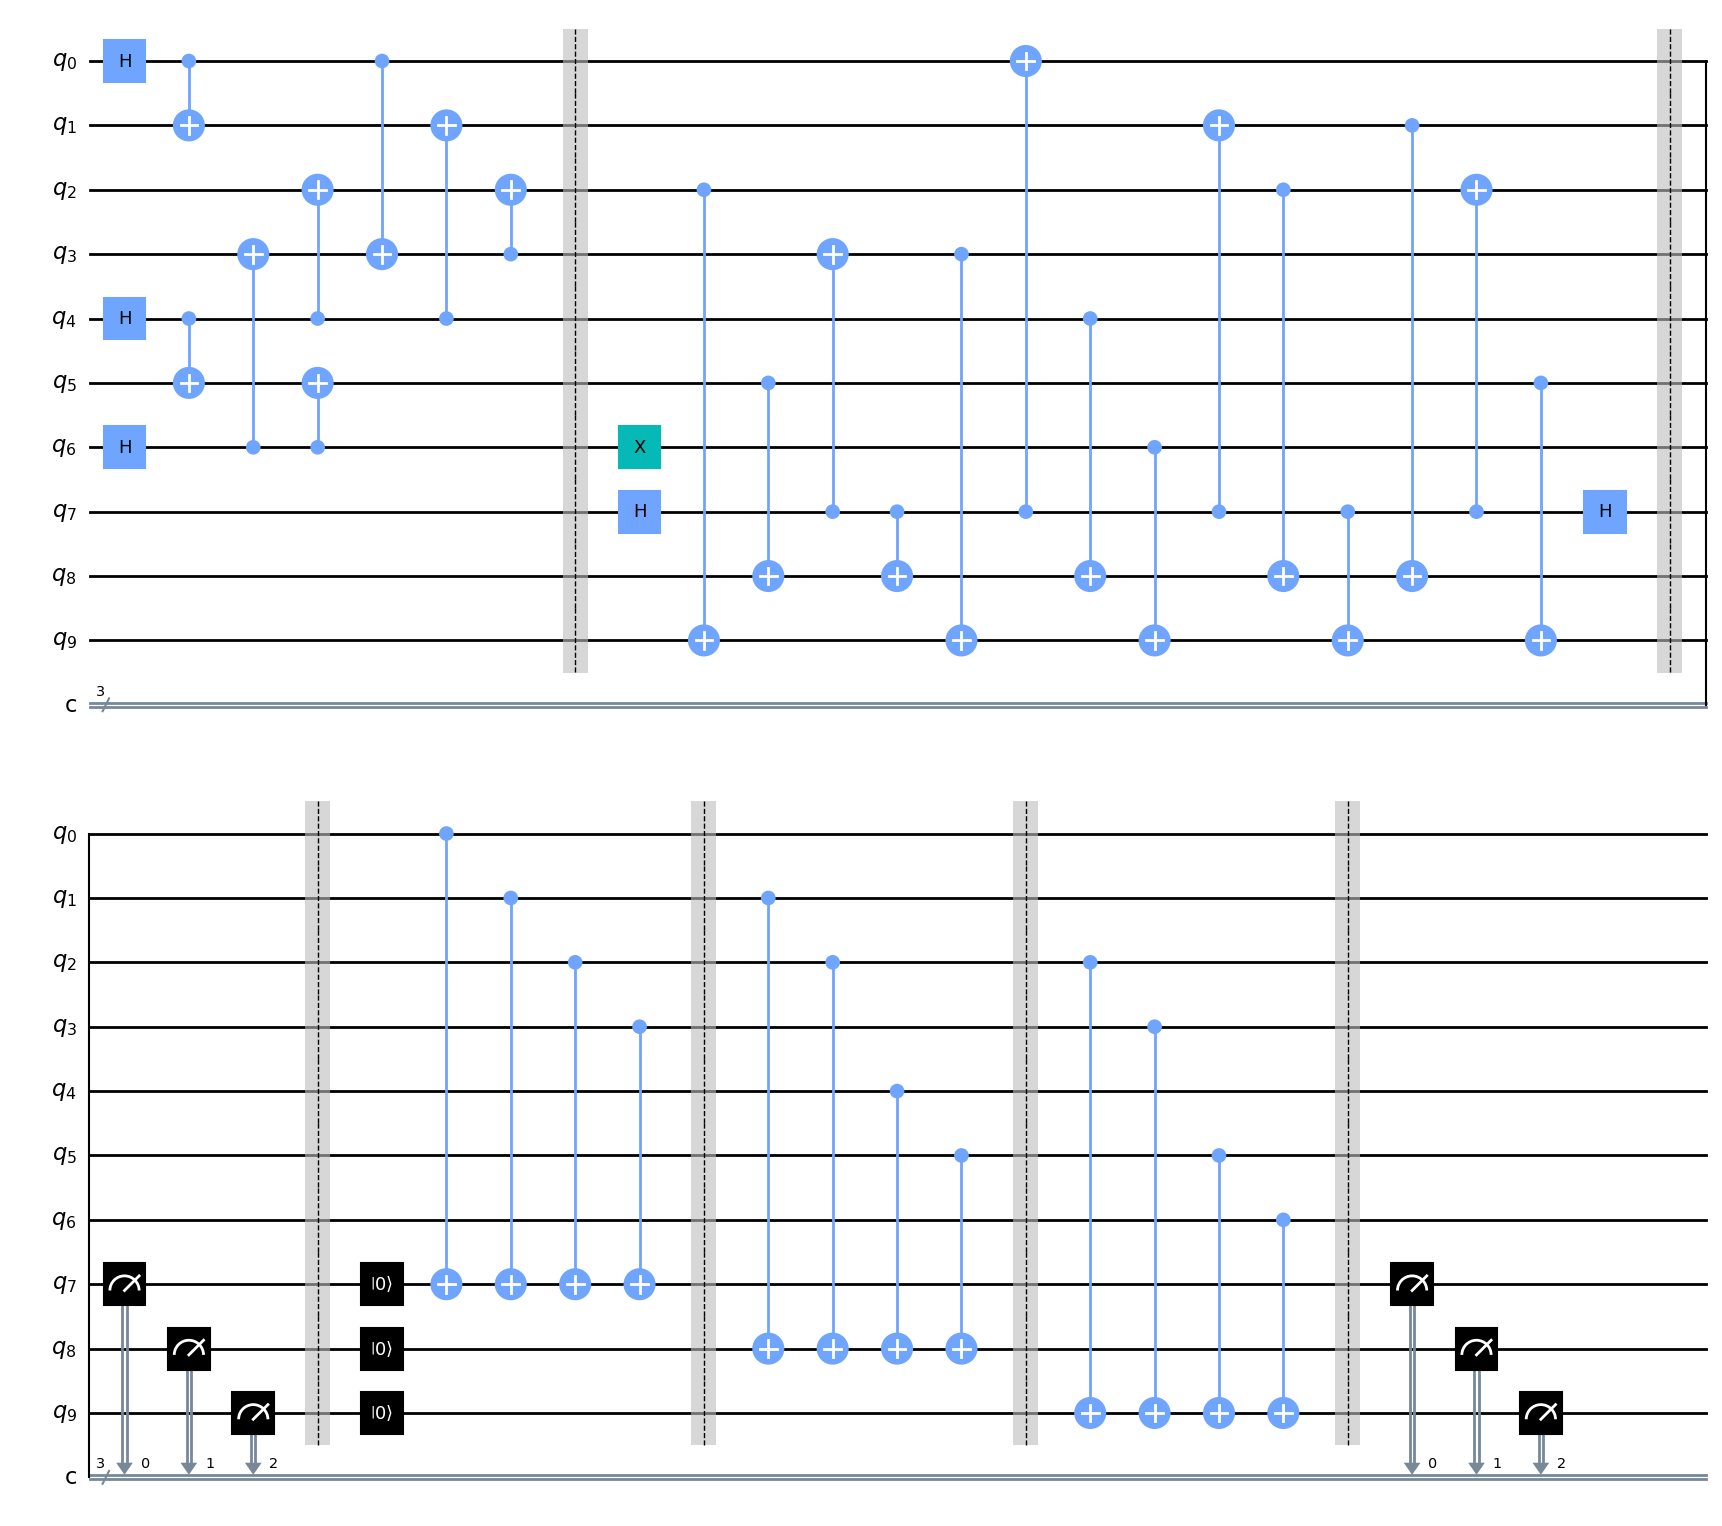

In [55]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flagged_syndrome_xzz_circuit = construct_flagged_syndrome_xzz_circuit(qreg, creg)
flagged_syndrome_xzz_circuit.draw('mpl')

In [56]:
# Run and get counts
result = simulator.run(flagged_syndrome_xzz_circuit.reverse_bits(), shots=1000).result()
counts = result.get_counts(flagged_syndrome_xzz_circuit)
# plot_histogram(counts, title='')
print(counts)

{'001': 1000}


Now, let's summarize the syndrome extraction work flow as:

1st flagged circuit $\rightarrow [S^f_1, S^f_5, S^f_6] = [0,0,1] \rightarrow [\Delta S^f_1, \Delta S^f_5, \Delta S^f_6] = [0,0,1] \rightarrow$ unflagged syndrome $\rightarrow [\Delta S_4, \Delta S_5, \Delta S_6] = [0,0,1]$ 

Then, these two types of syndrome will be send to the decoder and update Pauli frame.

### Hook qubit error

The following is an example of single qubit bit-flip $X$ error happening on the 8-th falg qubit. This hook error can not be detected with stabilizer $X_2X_3X_5X_6$!

In [57]:
def construct_hook_error_circuit(qreg, creg):
    hook_error_circuit = QuantumCircuit(qreg, creg)

    hook_error_circuit &= encoding_circuit

    # Adding single qubit error on 8-th data qubit
    # flagged_syndrome_xzz_circuit.y(qreg[7])

    hook_error_circuit.h(qreg[7])
    hook_error_circuit.cx(qreg[7],qreg[3])
    hook_error_circuit.cx(qreg[2],qreg[9])
    hook_error_circuit.cx(qreg[5],qreg[8])
    hook_error_circuit.cx(qreg[7],qreg[8])
    hook_error_circuit.cx(qreg[7],qreg[0])
    hook_error_circuit.cx(qreg[3],qreg[9])
    hook_error_circuit.cx(qreg[4],qreg[8])

    # Adding hook qubit error on ancilla qubit
    hook_error_circuit.x(qreg[7])

    hook_error_circuit.cx(qreg[7],qreg[1])
    hook_error_circuit.cx(qreg[6],qreg[9])
    hook_error_circuit.cx(qreg[2],qreg[8])
    hook_error_circuit.cx(qreg[7],qreg[9])
    hook_error_circuit.cx(qreg[7],qreg[2])
    hook_error_circuit.cx(qreg[5],qreg[9])
    hook_error_circuit.cx(qreg[1],qreg[8])
    hook_error_circuit.h(qreg[7])

    hook_error_circuit.barrier()

    hook_error_circuit.measure(qreg[7], creg[0])
    hook_error_circuit.measure(qreg[8], creg[1])
    hook_error_circuit.measure(qreg[9], creg[2])

    return hook_error_circuit


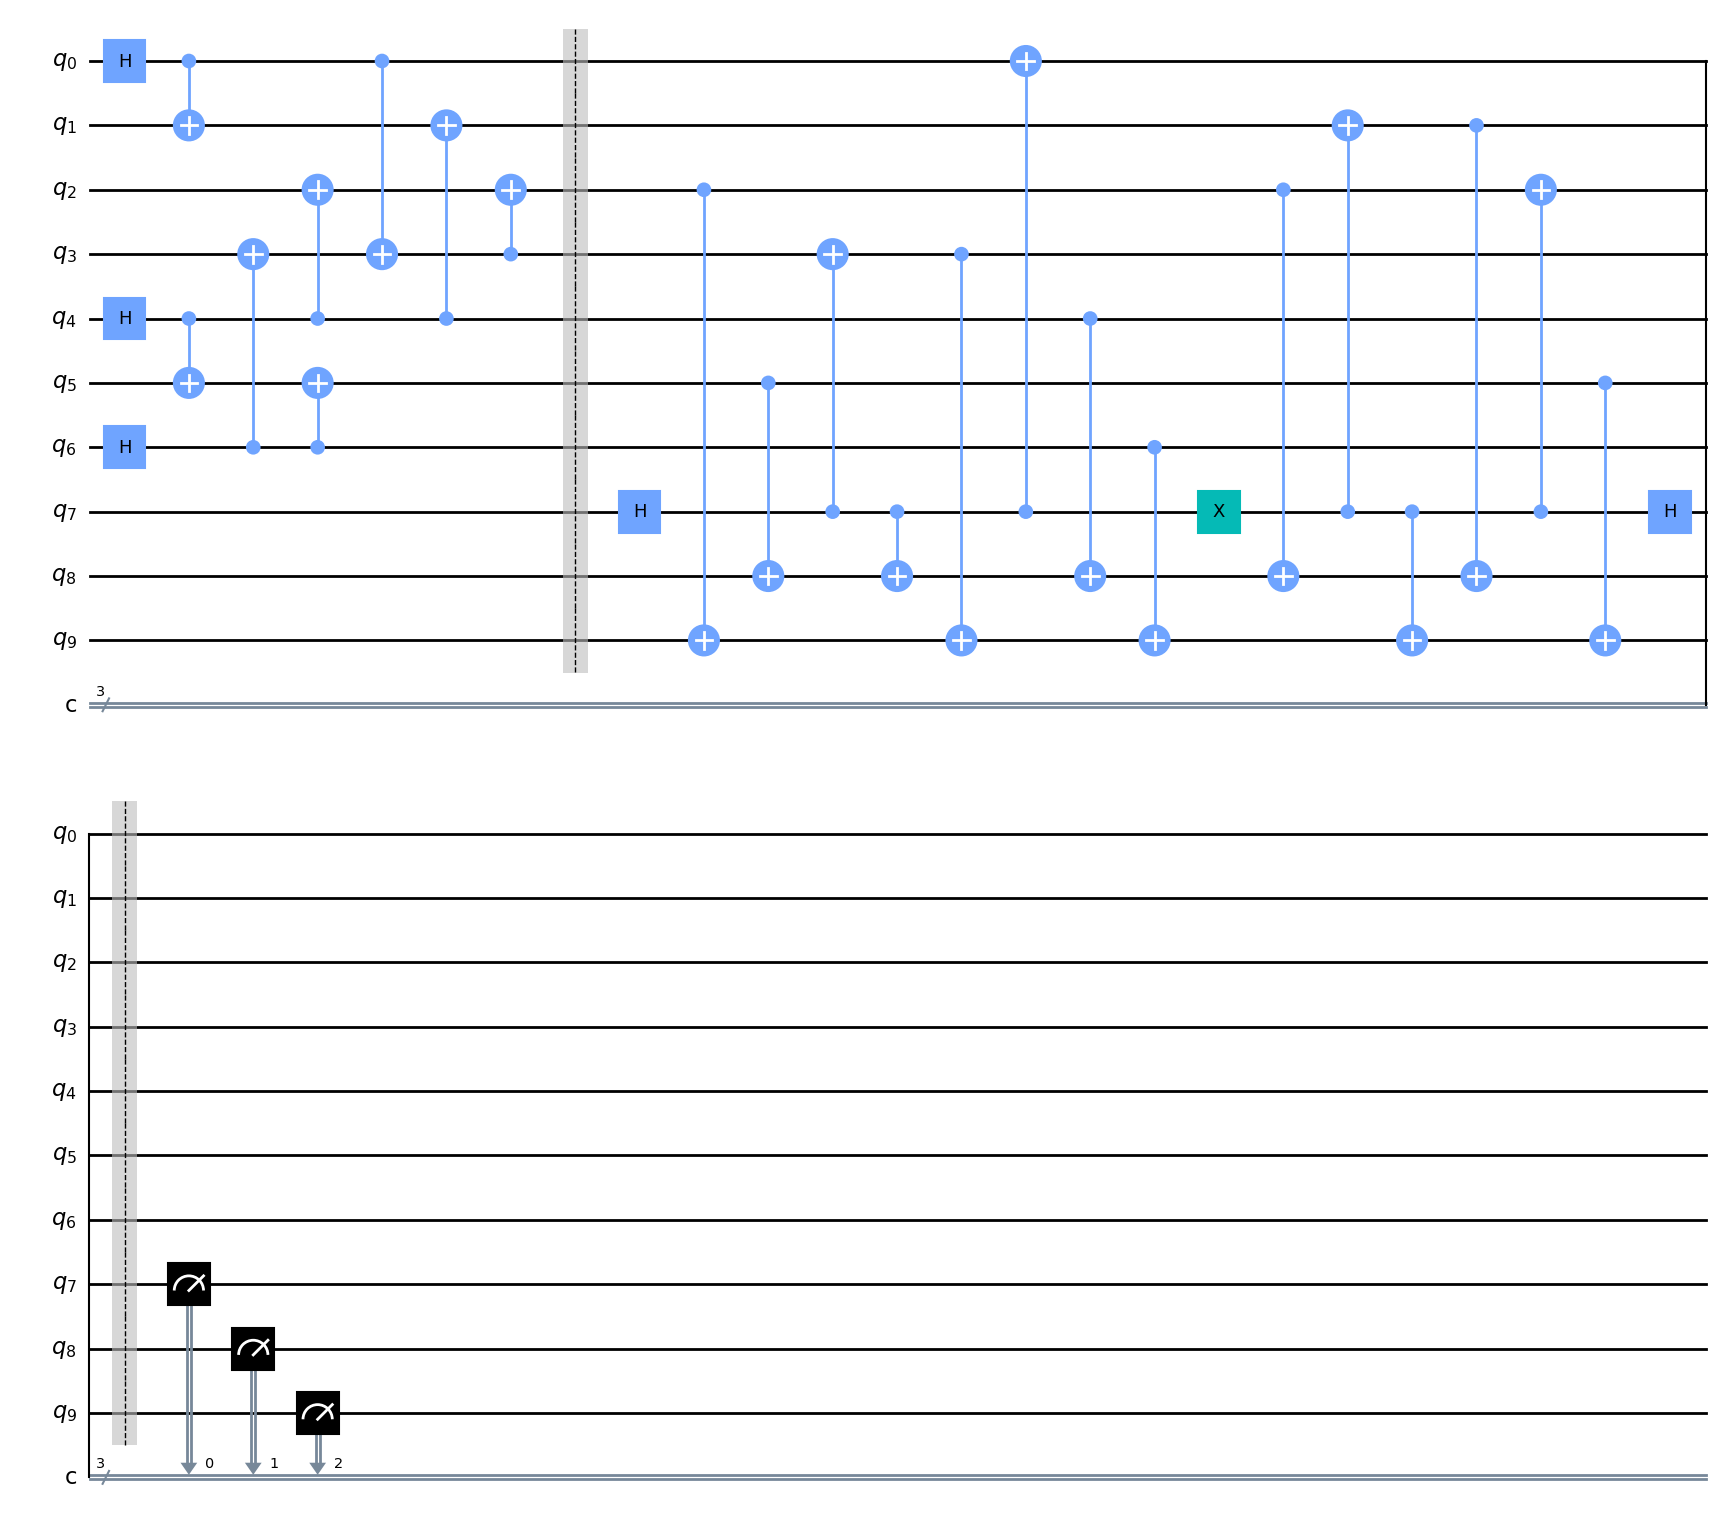

In [58]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

hook_error_circuit = construct_hook_error_circuit(qreg, creg)
hook_error_circuit.draw('mpl')

In [59]:
# Run and get counts
result = simulator.run(hook_error_circuit.reverse_bits(), shots=1000).result()
counts = result.get_counts(hook_error_circuit)
# plot_histogram(counts, title='')
print(counts)

{'011': 1000}


Now, let's interpret the results. We get a measurement result of $011$. **Notice this is a weight-2 error!**

- The first flag ancilla qubit checks $S^f_1 = X_1X_2X_3X_4$. $0$ tells us there is no $Z$ error happening on those qubit. 

- The second flag ancilla qubit checks $S^f_5 = Z_2Z_3Z_5Z_6$. $1$ tells us there is one $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S^f_6 = Z_3Z_4Z_6Z_7$. $1$ tells us there is one $X$ error happening on those qubit.


![](./pic/HookError_Quantinuum.png)

## Second flagged parallel circuit $\{S^f_2, S^f_3, S^f_4\}$

<img src="./pic/second-flag.png" width="500"/>

### Single qubit error

In [60]:
def construct_flagged_parallel_circuit_2(qreg, creg):
    flagged_parallel_circuit_2 = QuantumCircuit(qreg, creg)

    flagged_parallel_circuit_2 &= encoding_circuit

    # Add single qubit bit-flip error
    flagged_parallel_circuit_2.z(qreg[5])
    flagged_parallel_circuit_2.barrier()

    # Syndrome S2, S3, S4
    flagged_parallel_circuit_2.h(qreg[8])
    flagged_parallel_circuit_2.h(qreg[9])
    flagged_parallel_circuit_2.cx(qreg[3], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[9], qreg[2])
    flagged_parallel_circuit_2.cx(qreg[8], qreg[5])

    flagged_parallel_circuit_2.cx(qreg[8], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[0], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[9], qreg[3])
    flagged_parallel_circuit_2.cx(qreg[8], qreg[4])
    flagged_parallel_circuit_2.cx(qreg[1], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[9], qreg[6])
    flagged_parallel_circuit_2.cx(qreg[8], qreg[2])
    flagged_parallel_circuit_2.cx(qreg[9], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[2], qreg[7])
    flagged_parallel_circuit_2.cx(qreg[8], qreg[1])
    flagged_parallel_circuit_2.cx(qreg[9], qreg[5])

    flagged_parallel_circuit_2.h(qreg[8])
    flagged_parallel_circuit_2.h(qreg[9])

    flagged_parallel_circuit_2.barrier()

    flagged_parallel_circuit_2.measure(qreg[7:], creg)

    return flagged_parallel_circuit_2


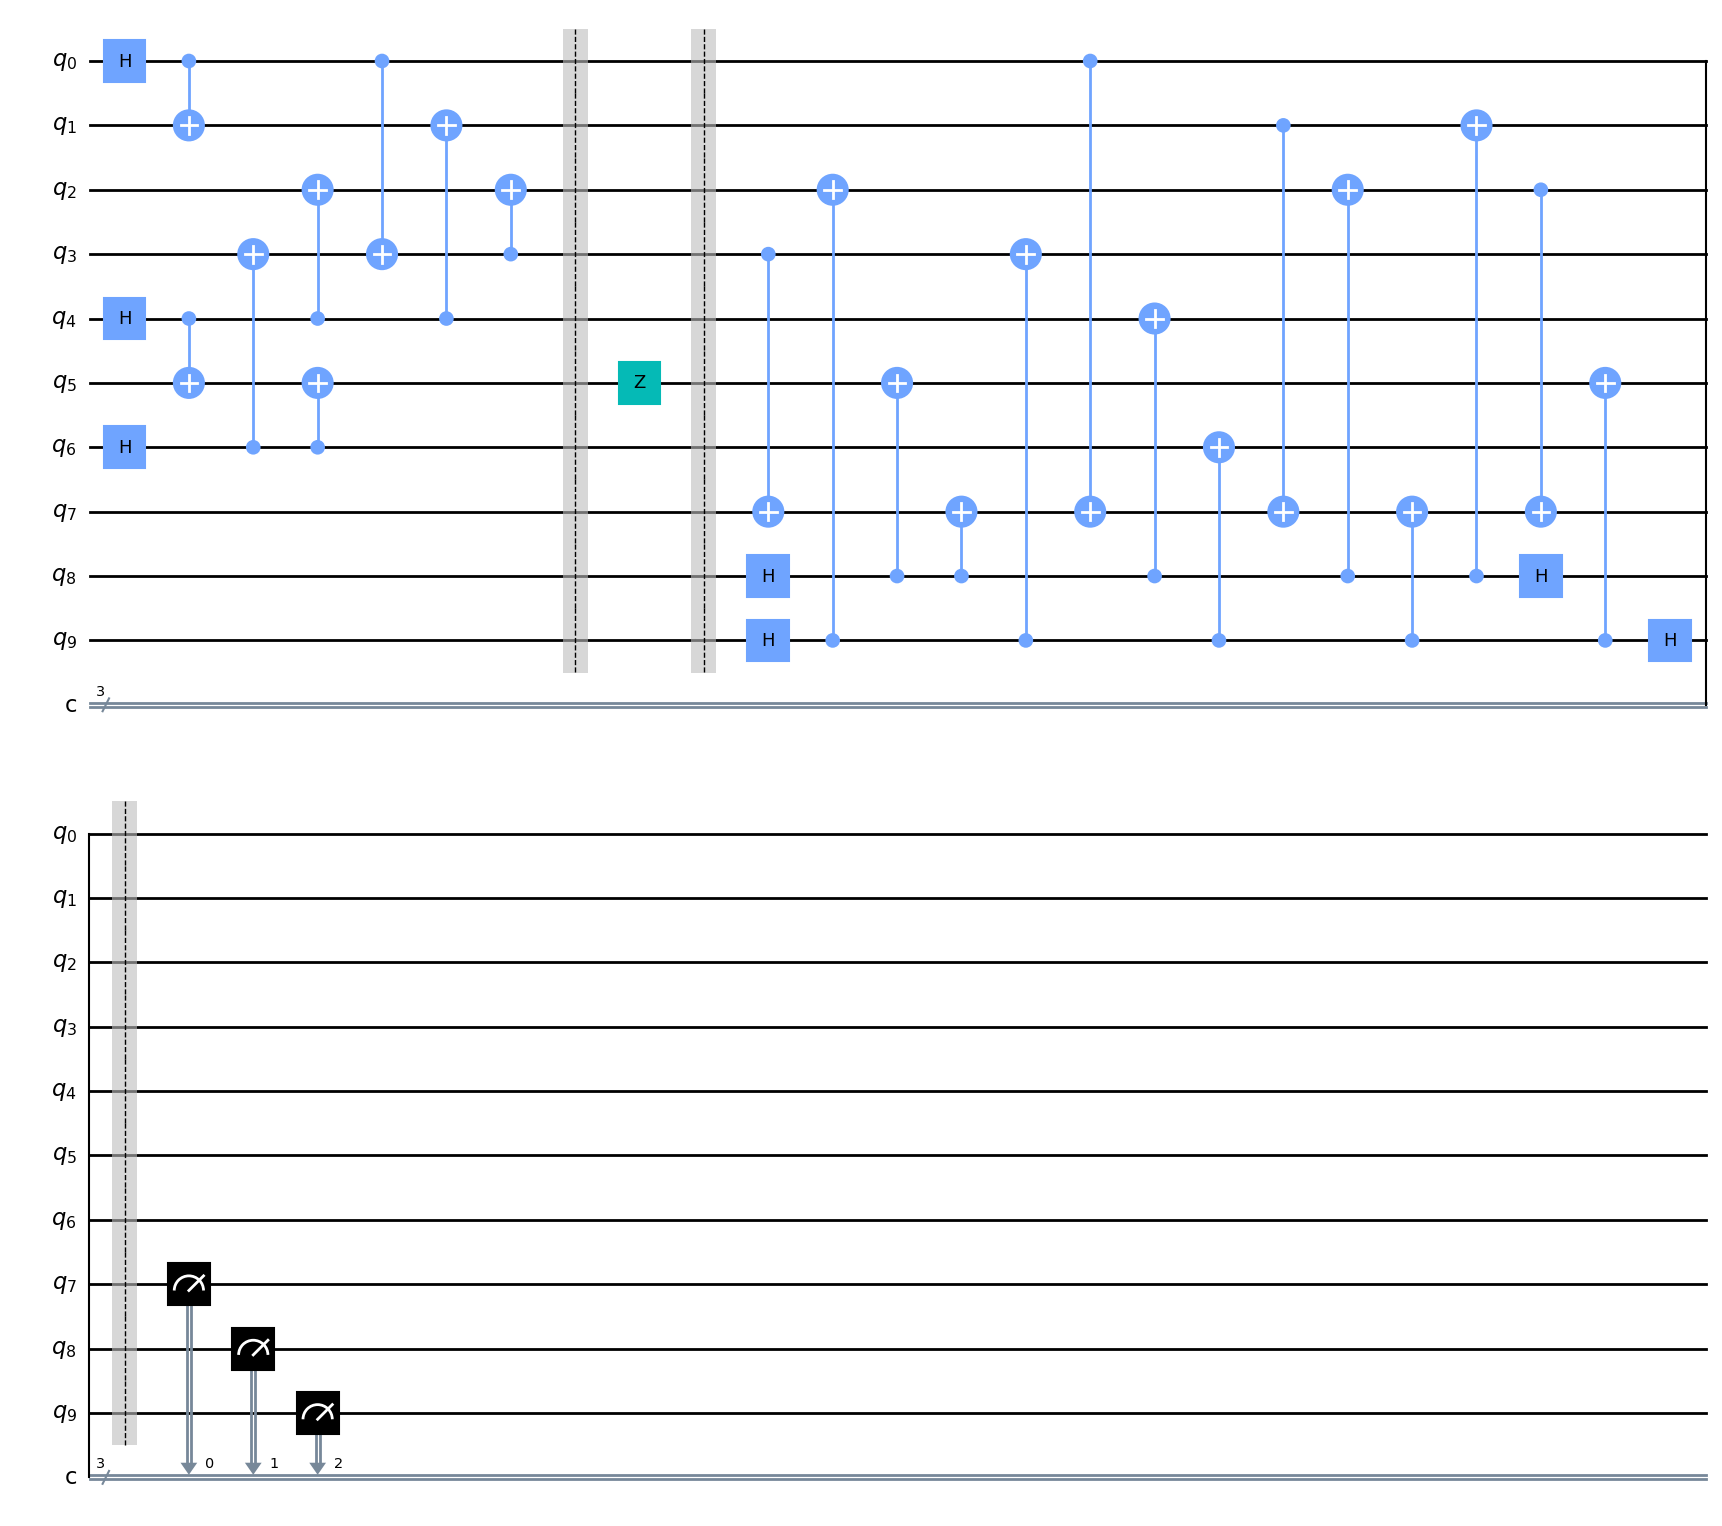

In [61]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flagged_parallel_circuit_2 = construct_flagged_parallel_circuit_2(qreg, creg)
flagged_parallel_circuit_2.draw("mpl", cregbundle=True)

In [62]:
# Run and get counts
result = simulator.run(flagged_parallel_circuit_2.reverse_bits(), shots=1000).result()
counts = result.get_counts(flagged_parallel_circuit_2)
print(counts)

{'011': 1000}


### Hook qubit error

---
Here is the code we want to generate from this section.

![](./pic/QEC-pseudo-code.png)

In [63]:
import qiskit.tools.jupyter
%qiskit_version_table